In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, RocCurveDisplay
)
import joblib
import warnings
warnings.filterwarnings("ignore")

In [3]:
# ---------- CONFIG ----------
DATA_PATH = r'C:\Users\chint\OneDrive\Documents\application_data.csv'   # <-- change to your filename
TARGET_COL = "TARGET"                # set to actual target column name in your data
RANDOM_STATE = 42
MODEL_PATH = "risk_model.joblib"

In [4]:
# ---------- Utilities ----------
def load_data(path: str) -> pd.DataFrame:
    assert os.path.exists(path), f"Data file not found: {path}"
    df = pd.read_csv(path)
    print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns.")
    return df

def quick_overview(df: pd.DataFrame, n: int = 5) -> None:
    print("=== HEAD ===")
    display(df.head(n))
    print("\n=== INFO ===")
    print(df.info())
    print("\n=== DESCRIBE (numerical) ===")
    display(df.describe().T)
    print("\nMissing value counts:")
    print(df.isnull().sum().sort_values(ascending=False).head(20))

In [5]:
import pandas as pd

DATA_PATH = r'C:\Users\chint\OneDrive\Documents\application_data.csv'
df = pd.read_csv(DATA_PATH)

In [6]:
print(df.shape)
print(df.columns)

(307511, 122)
Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


In [9]:
TARGET = "TARGET"
SAVE_PLOTS = False           # set True if you want to save images
PLOT_DIR = "eda_plots"
if SAVE_PLOTS:
    os.makedirs(PLOT_DIR, exist_ok=True)

In [17]:
from typing import List, Tuple

# -------------------------
# Function: Detect feature types
# -------------------------
def identify_feature_types(df: pd.DataFrame, target: str) -> Tuple[List[str], List[str]]:
    """
    Identify numeric and categorical feature columns, excluding the target.

    Args:
        df (pd.DataFrame): Input dataframe.
        target (str): Name of the target column.

    Returns:
        Tuple[List[str], List[str]]: (numeric_columns, categorical_columns)
    """
    # Exclude target from columns
    cols = [c for c in df.columns if c != target]

    # Numeric columns
    numeric_cols = df[cols].select_dtypes(include=["int64", "float64"]).columns.tolist()

    # Categorical columns
    categorical_cols = df[cols].select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    # Treat low-cardinality numeric columns as categorical
    for col in numeric_cols.copy():
        if df[col].nunique() < 10:
            numeric_cols.remove(col)
            categorical_cols.append(col)

    return numeric_cols, categorical_cols


# -------------------------
# Usage
# -------------------------
numeric_cols, categorical_cols = identify_feature_types(df, TARGET)
print("Numeric cols:", numeric_cols[:10], "...")
print("Categorical cols:", categorical_cols[:10], "...")


Numeric cols: ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION'] ...
Categorical cols: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'] ...


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
#-------------------------
# Helper to save plots
# -------------------------
def save_plot(fig, name):
    if SAVE_PLOTS:
        path = os.path.join(PLOT_DIR, f"{name}.png")
        fig.savefig(path, bbox_inches='tight')
        print(f"Saved plot: {path}")
    plt.show()

In [22]:
# -------------------------
# EDA Plots
# -------------------------
def plot_target_distribution(df, target):
    fig = plt.figure(figsize=(6,4))
    sns.countplot(x=target, data=df, palette="Set2")
    plt.title(f"{target} Distribution")
    plt.xlabel(target)
    plt.ylabel("Count")
    save_plot(fig, f"target_distribution")

def plot_numeric_distributions(df, numeric_cols):
    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12,4))
        sns.histplot(df[col], kde=True, ax=axes[0], color="skyblue")
        axes[0].set_title(f"{col} Histogram")
        sns.boxplot(x=df[col], ax=axes[1], color="lightgreen")
        axes[1].set_title(f"{col} Boxplot")
        save_plot(fig, f"numeric_{col}")

def plot_categorical_counts(df, categorical_cols, top_n=10):
    for col in categorical_cols:
        fig = plt.figure(figsize=(8,4))
        top_categories = df[col].value_counts().nlargest(top_n)
        sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")
        plt.title(f"{col} Counts (Top {top_n})")
        plt.xticks(rotation=45)
        save_plot(fig, f"categorical_{col}")

def plot_correlation_heatmap(df, numeric_cols):
    corr = df[numeric_cols].corr()
    fig = plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Numeric Feature Correlation")
    save_plot(fig, "correlation_heatmap")

def plot_target_vs_numeric(df, target, numeric_cols):
    for col in numeric_cols:
        fig = plt.figure(figsize=(6,4))
        sns.boxplot(x=target, y=col, data=df, palette="Set2")
        plt.title(f"{col} vs {target}")
        save_plot(fig, f"{col}_vs_{target}")

def plot_target_vs_categorical(df, target, categorical_cols, top_n=10):
    for col in categorical_cols:
        fig = plt.figure(figsize=(8,4))
        top_categories = df[col].value_counts().nlargest(top_n).index
        sns.countplot(x=col, hue=target, data=df[df[col].isin(top_categories)], palette="Set1")
        plt.title(f"{col} vs {target} (Top {top_n})")
        plt.xticks(rotation=45)
        save_plot(fig, f"{col}_vs_{target}")

Numeric columns: ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION'] ...
Categorical columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'] ...


C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target, data=df, palette="Set2")


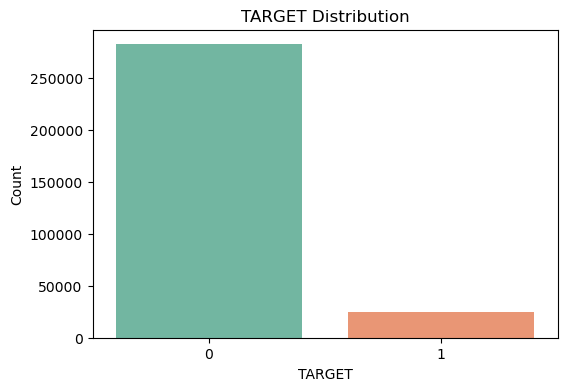

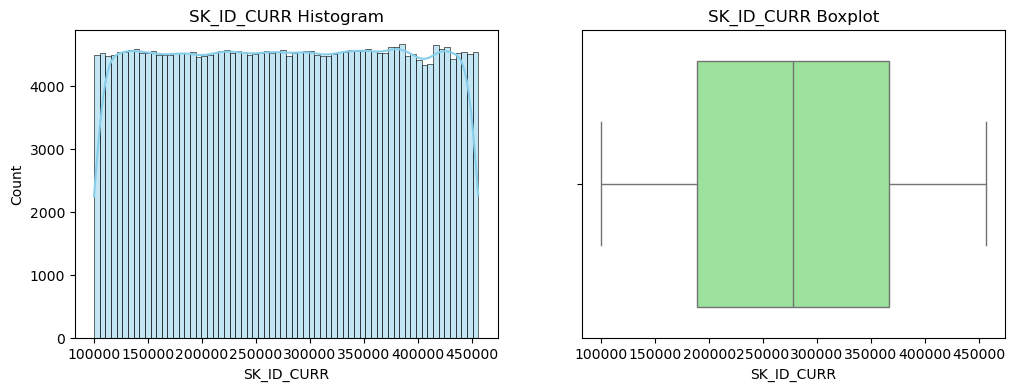

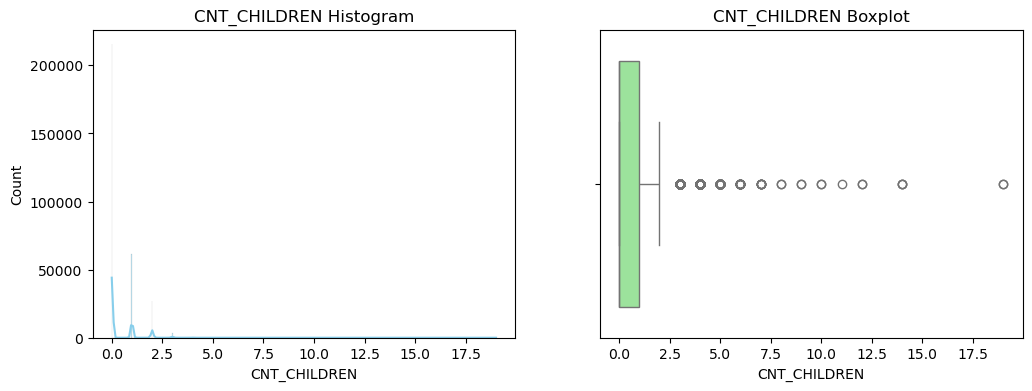

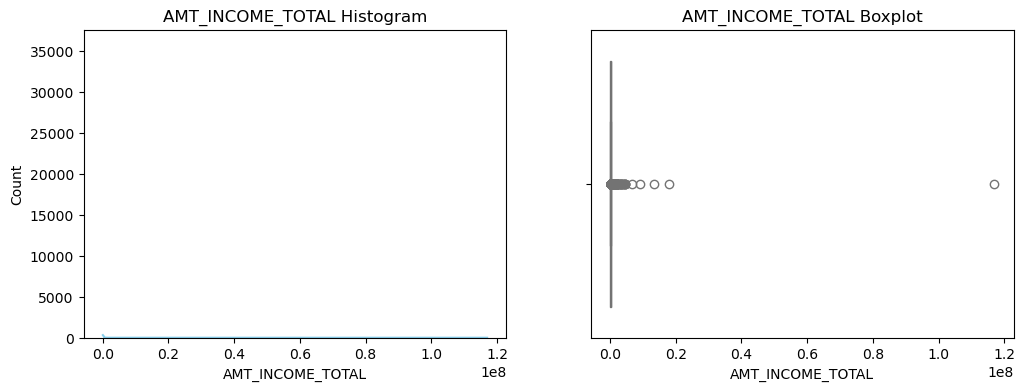

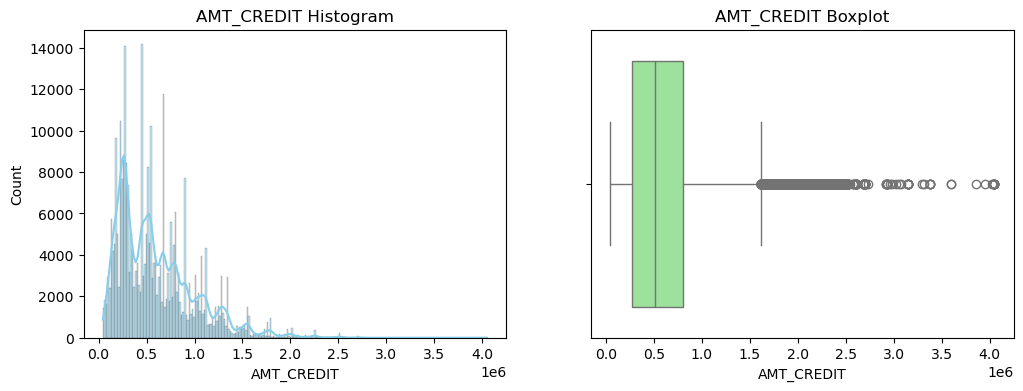

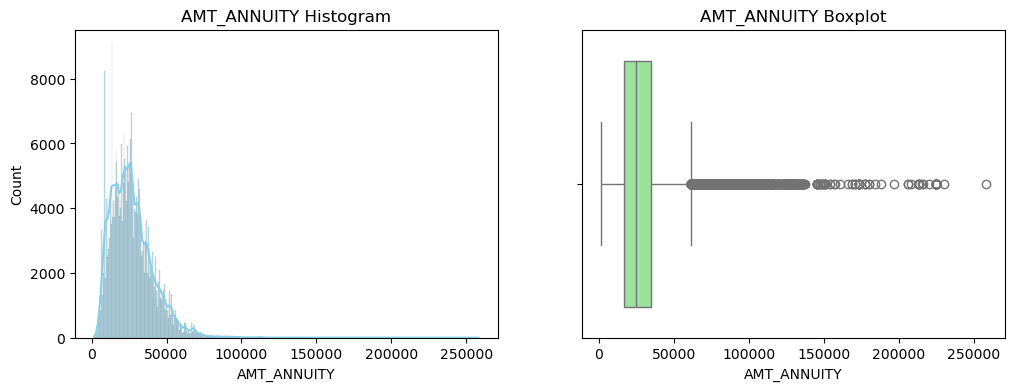

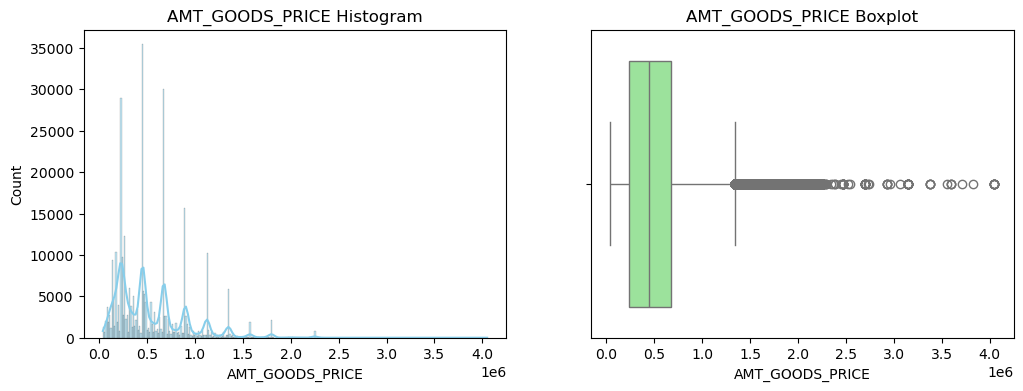

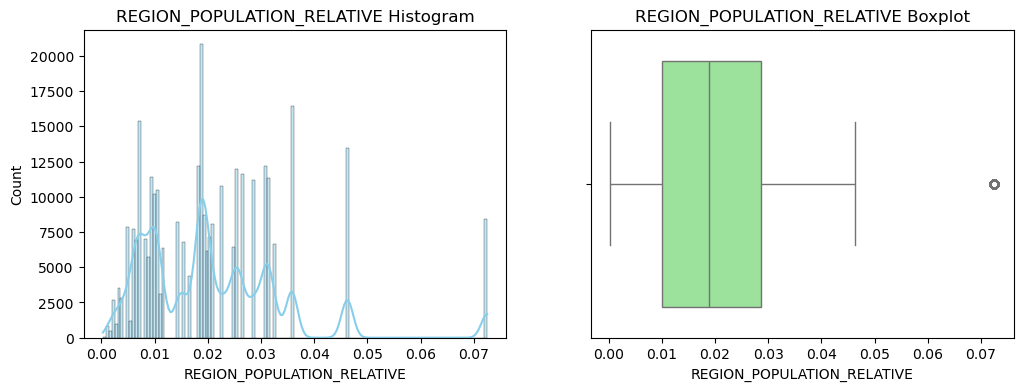

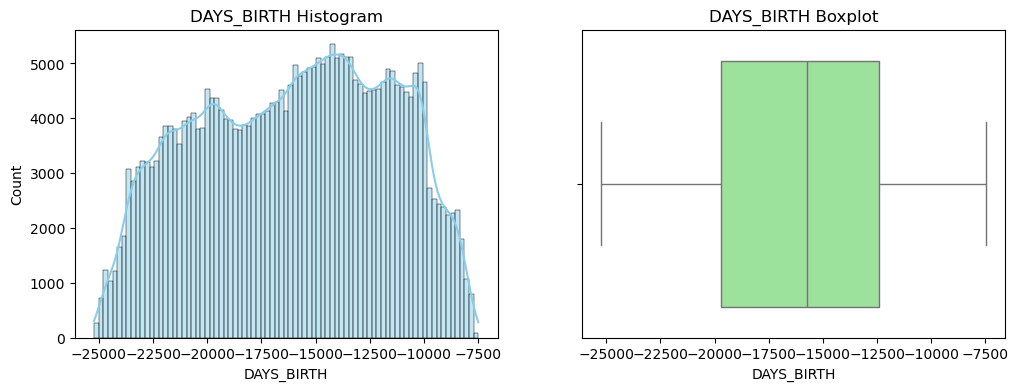

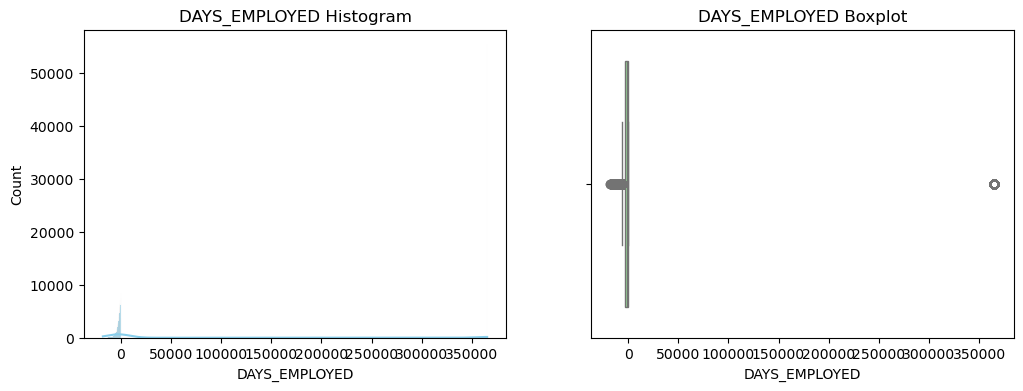

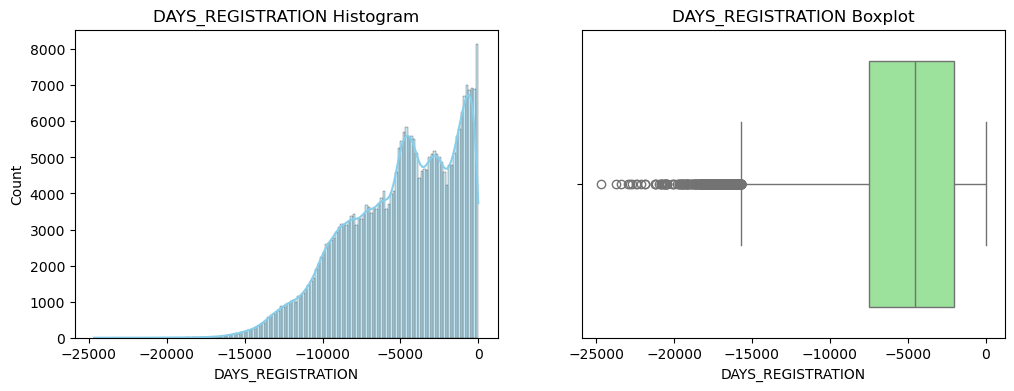

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")


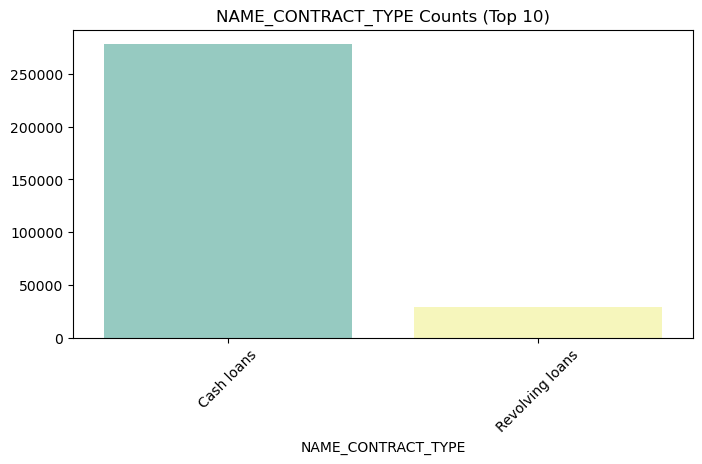

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")


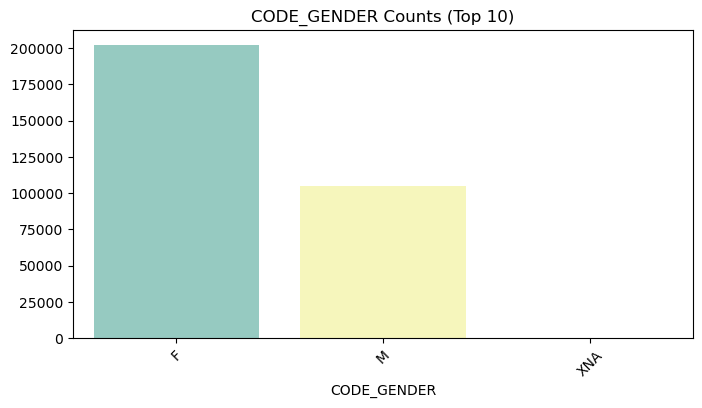

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")


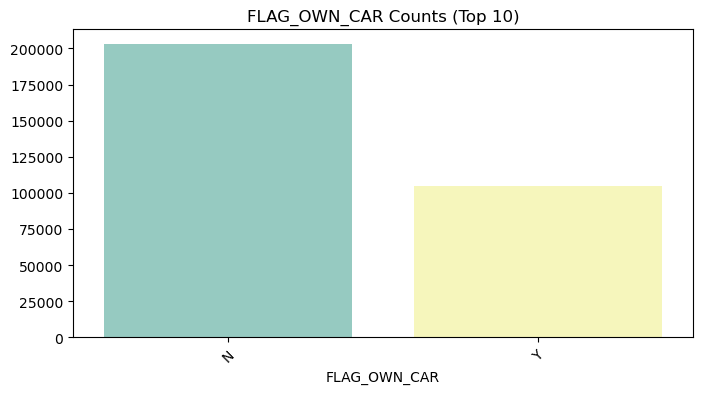

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")


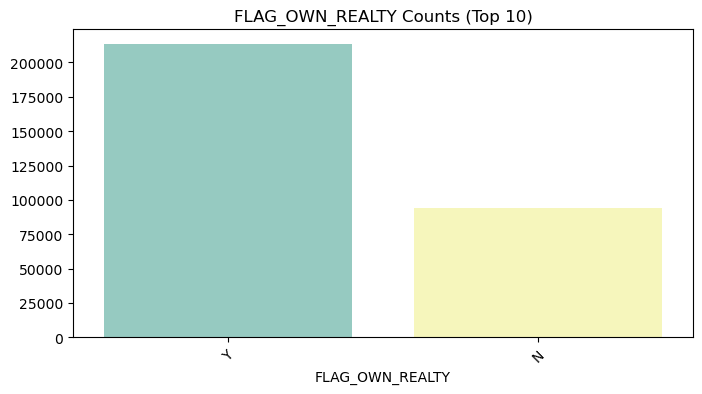

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")


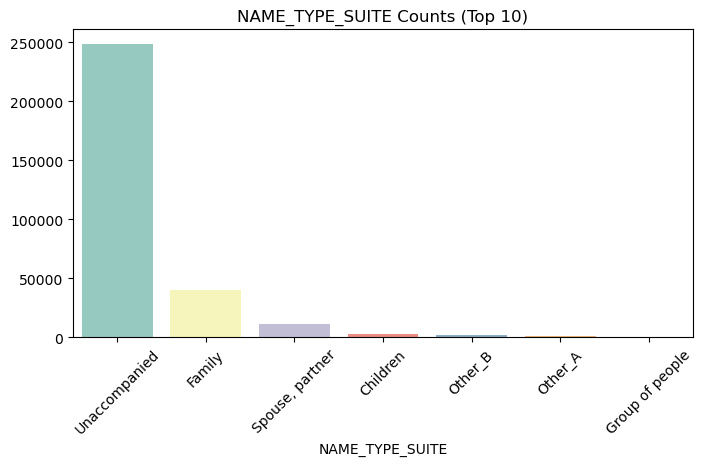

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")


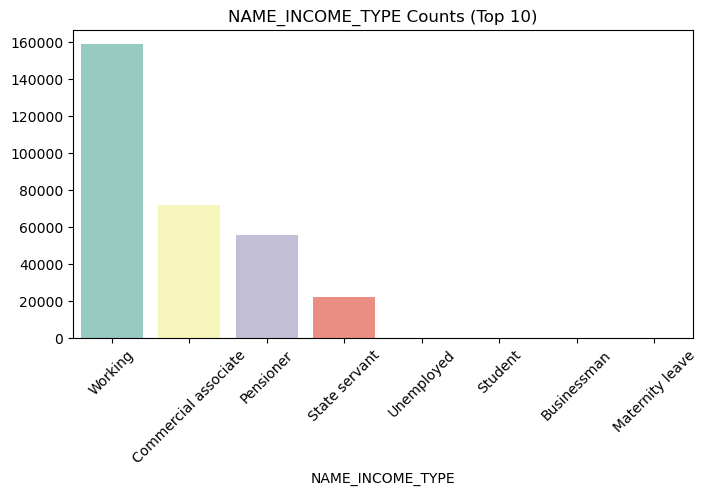

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")


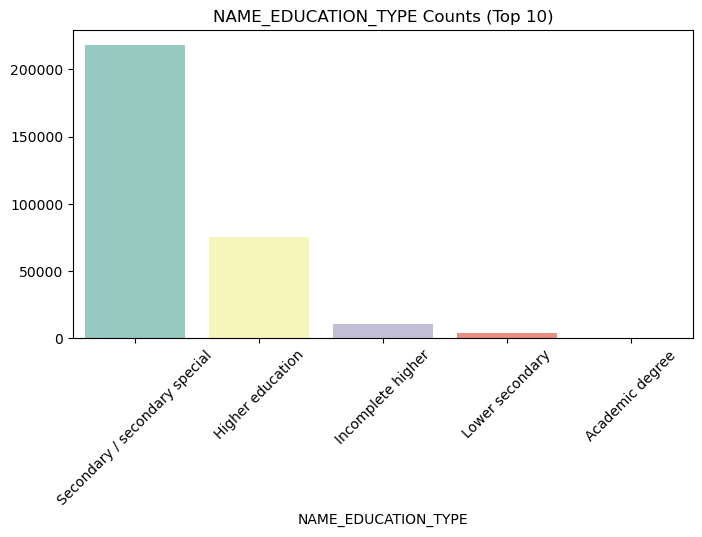

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")


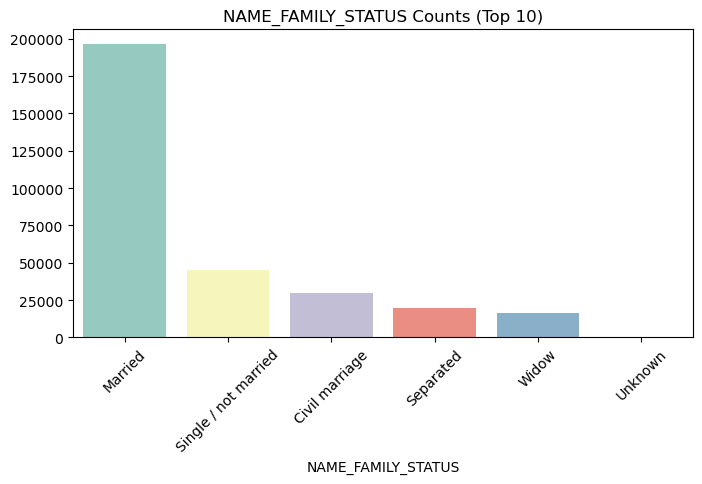

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")


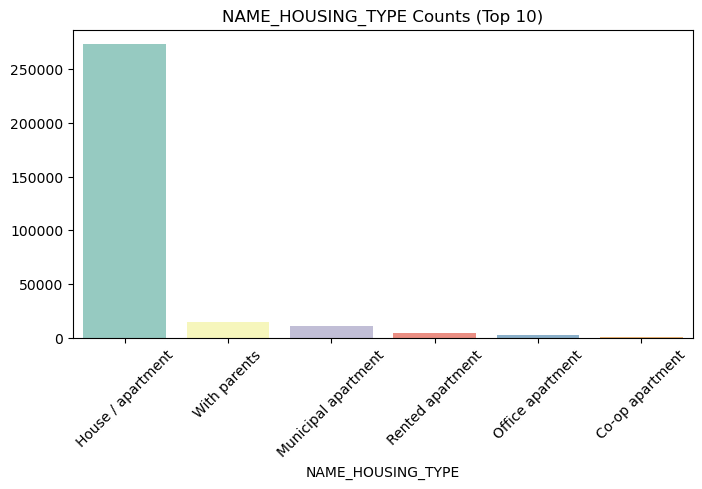

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="Set3")


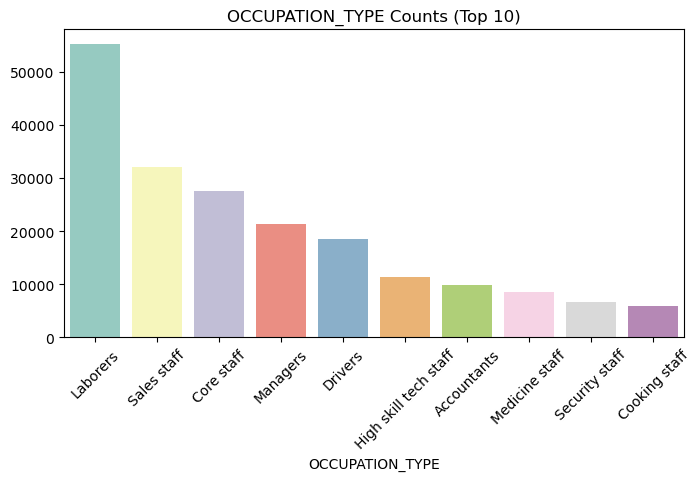

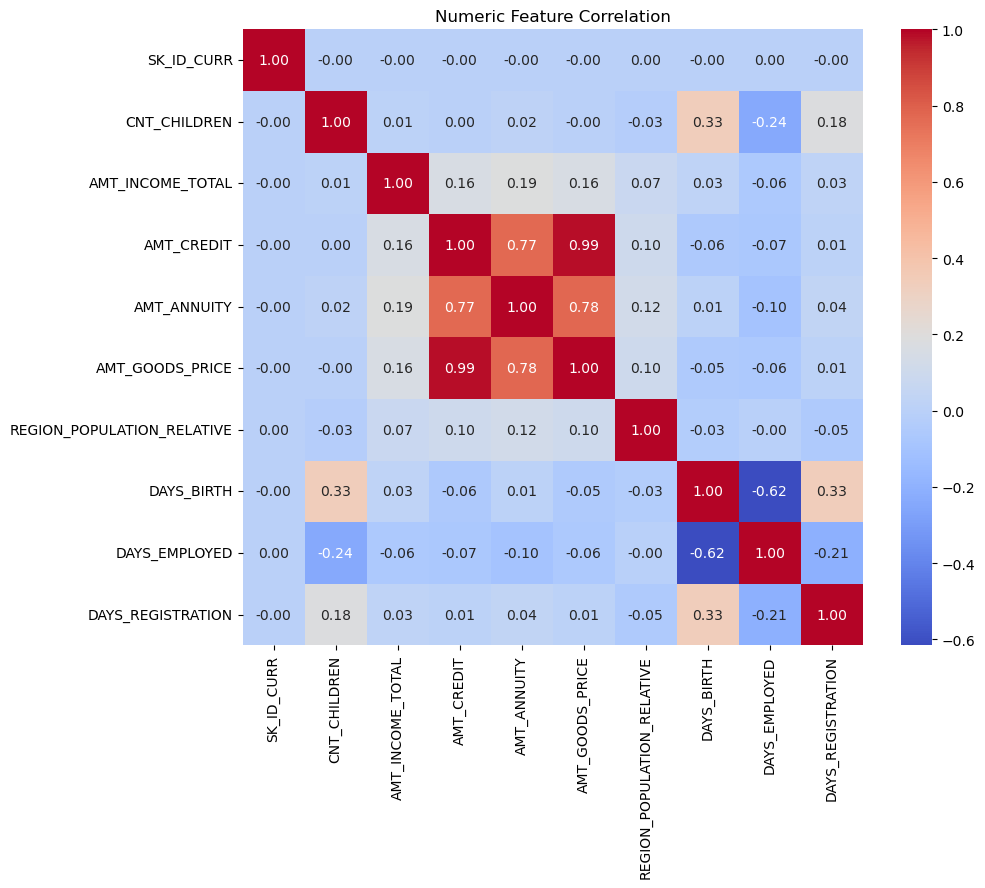

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


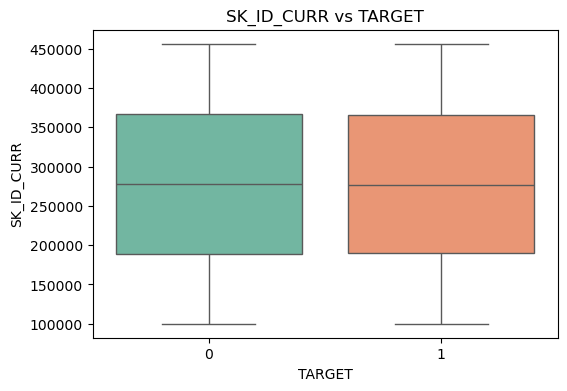

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


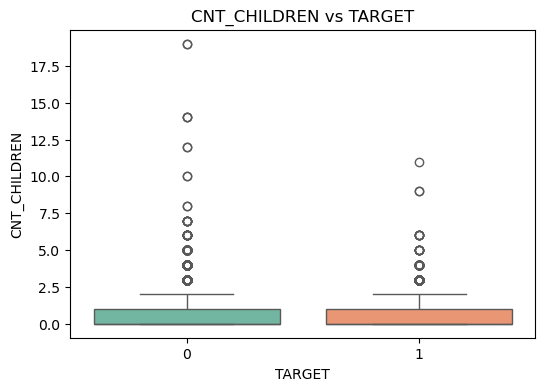

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


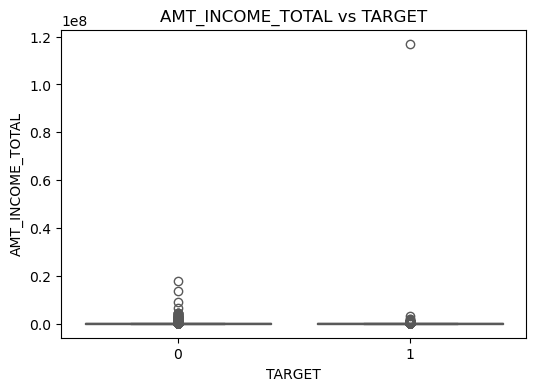

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


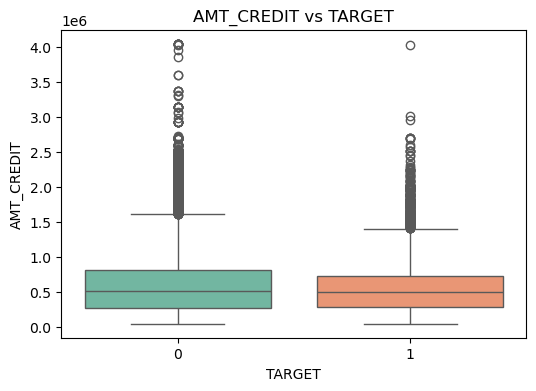

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


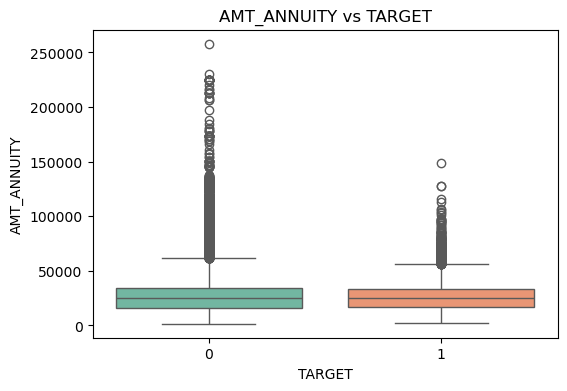

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


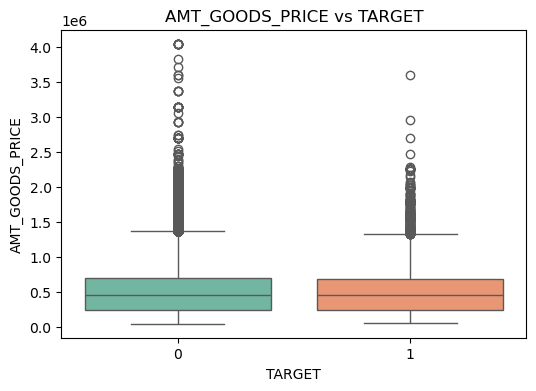

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


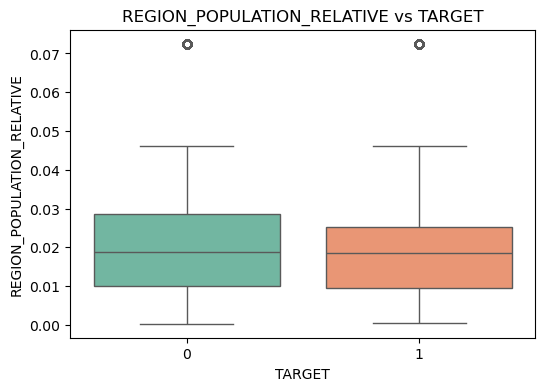

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


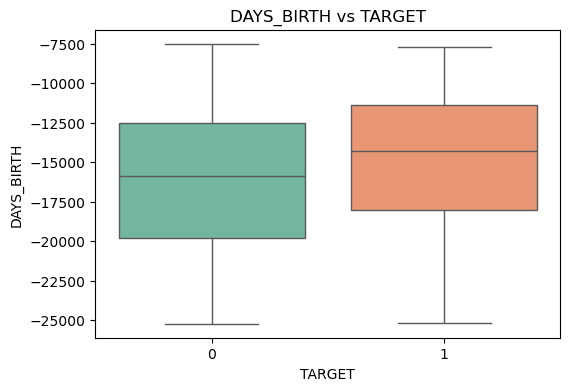

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


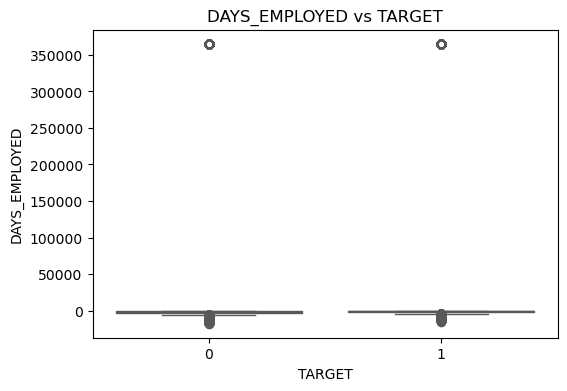

C:\Users\chint\AppData\Local\Temp\ipykernel_9900\640113118.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette="Set2")


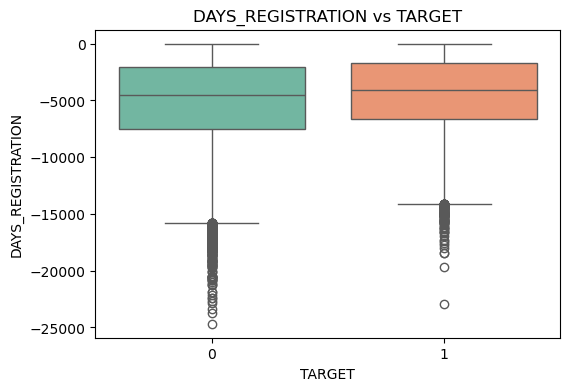

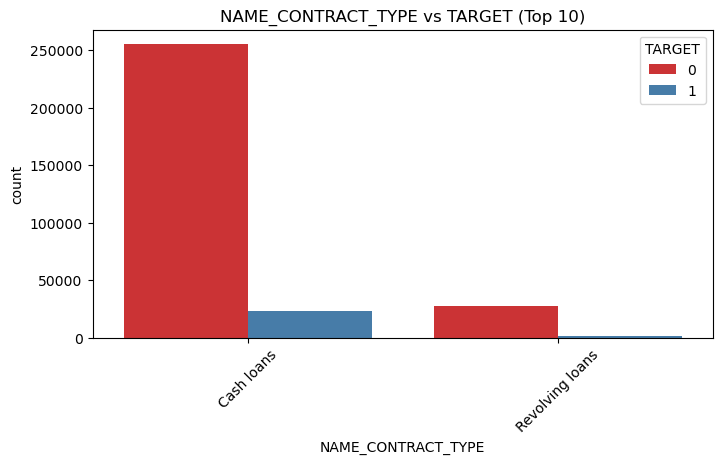

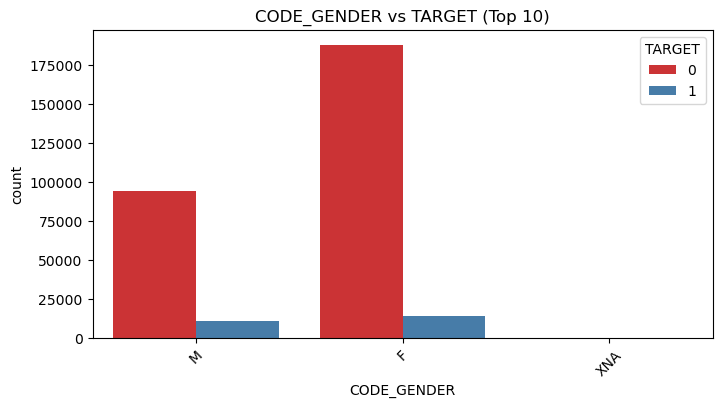

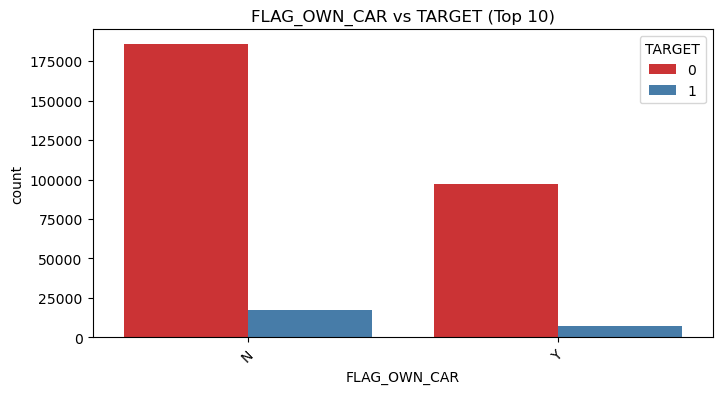

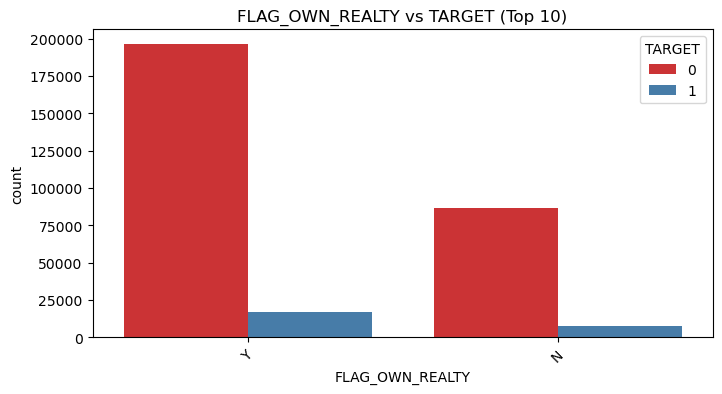

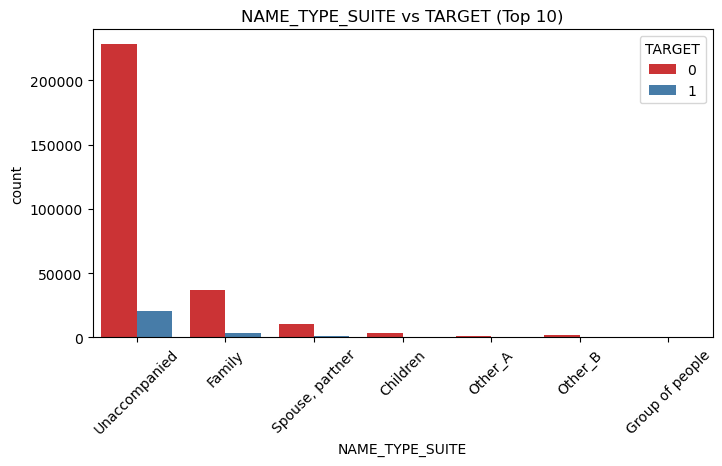

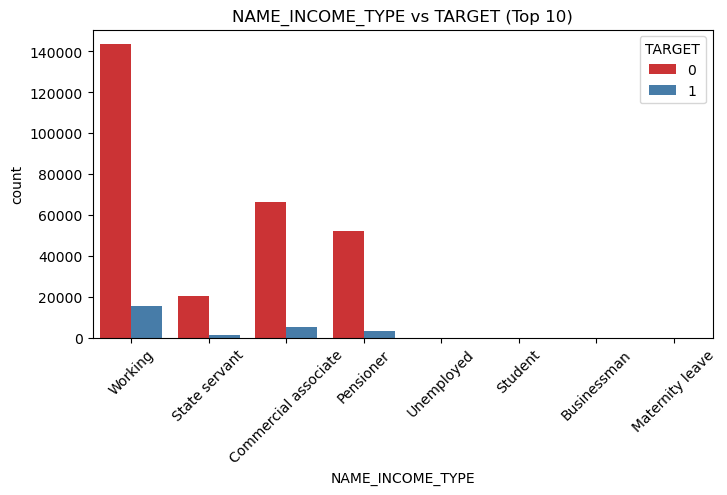

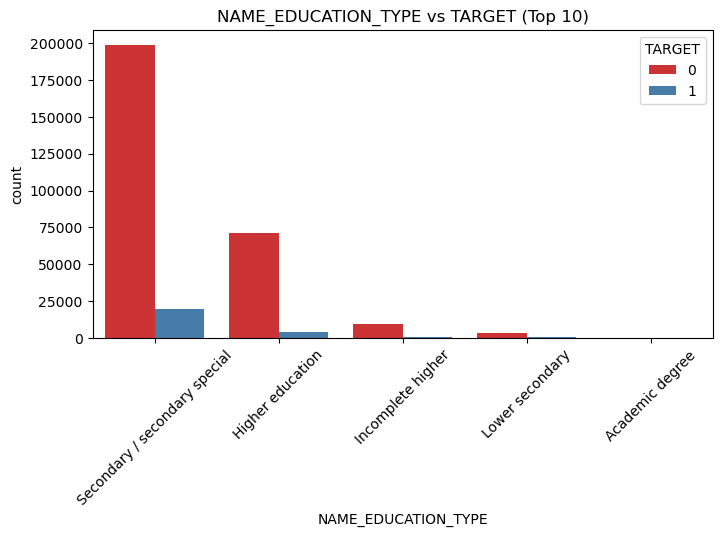

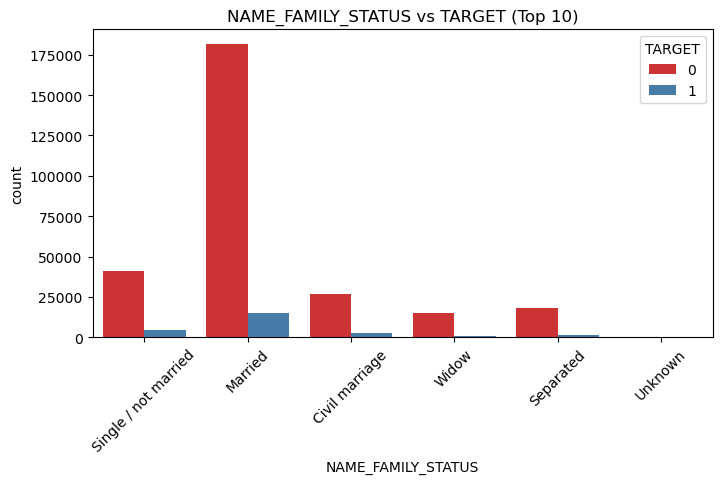

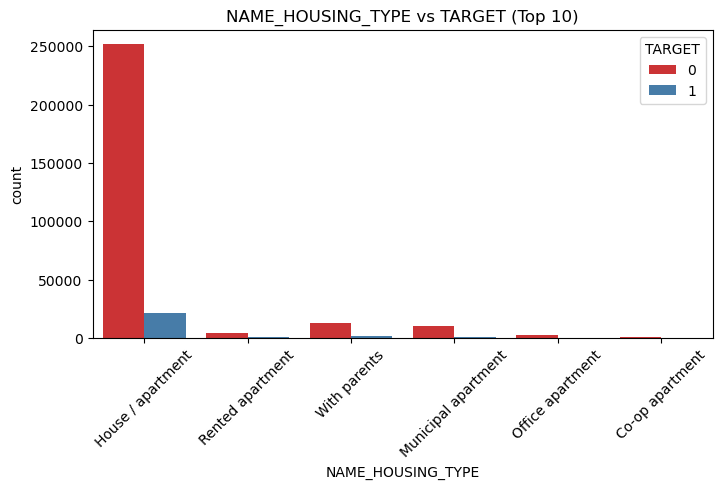

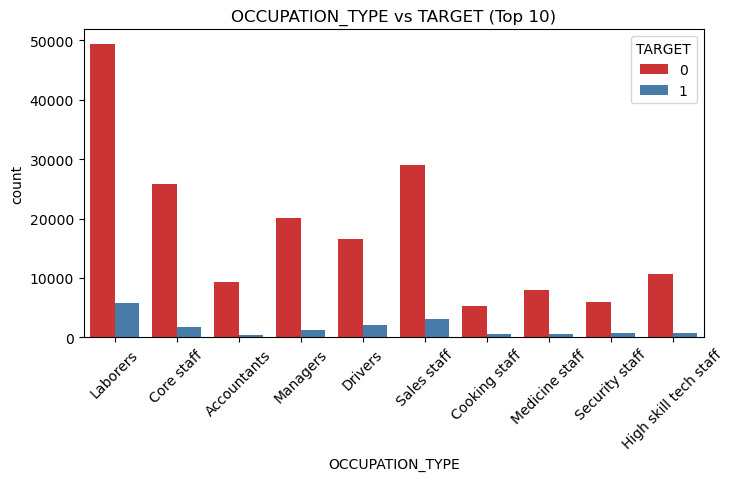

✅ All EDA plots saved in folder: eda_plots


In [23]:
# -------------------------
# Run EDA
# -------------------------
numeric_cols, categorical_cols = identify_feature_types(df, TARGET)
print("Numeric columns:", numeric_cols[:10], "...")  # show first 10 for brevity
print("Categorical columns:", categorical_cols[:10], "...")

plot_target_distribution(df, TARGET)
plot_numeric_distributions(df, numeric_cols[:10])  # first 10 numeric columns
plot_categorical_counts(df, categorical_cols[:10]) # first 10 categorical columns
plot_correlation_heatmap(df, numeric_cols[:10])    # correlation of first 10 numeric
plot_target_vs_numeric(df, TARGET, numeric_cols[:10])
plot_target_vs_categorical(df, TARGET, categorical_cols[:10])

print("✅ All EDA plots saved in folder:", PLOT_DIR)

In [24]:
 def add_basic_features(df: pd.DataFrame) -> pd.DataFrame:
    if "days_employed" in df.columns:
        df["days_employed_abs"] = df["days_employed"].abs()
    if {"income_total", "family_size"}.issubset(df.columns):
        df["income_per_person"] = df["income_total"] / (df["family_size"].replace({0: 1}))
    return df

In [25]:
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
for col in categorical_cols:
    df[col] = df[col].astype("string")


In [36]:
# ---------- Preprocessing & Pipeline ----------
import sklearn

def build_preprocessing_pipeline(numeric_cols: List[str], categorical_cols: List[str]):
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    # check sklearn version
    if int(sklearn.__version__.split(".")[1]) >= 2:  # 1.2+
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    else:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", ohe)
    ])
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])
    return preprocessor



Numeric cols: ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'] ...
Categorical cols: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'] ...

Training LogisticRegression ...
LogisticRegression ROC AUC: 0.7301 ± 0.0084

Training RandomForest ...
RandomForest ROC AUC: 0.6906 ± 0.0118

Selected model: LogisticRegression

📊 Metrics on sampled dataset: {'accuracy': 0.7019, 'precision': 0.17704280155642024, 'recall': 0.7187120291616039, 'f1': 0.2841018251681076, 'roc_auc': 0.7767847295347565}

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.70      0.81     18354
           1       0.18      0.72      0.28      1646

    accuracy                         

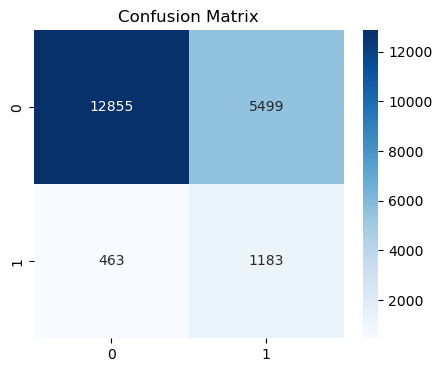

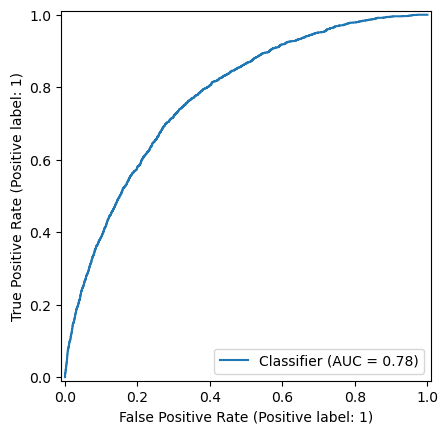

✅ Model saved at risk_model_sample.joblib


In [39]:
# -------------------------
# Training & Evaluation (Standalone, clean)
# -------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from typing import List, Tuple
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay
)

# -------------------------
# Parameters
# -------------------------
SAMPLE_SIZE = 20000
CV_FOLDS = 3
RANDOM_STATE = 42
MODEL_PATH = "risk_model_sample.joblib"

# -------------------------
# Sample dataset for fast testing
# -------------------------
df_sample = df.sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
X = df_sample.drop(columns=[TARGET])
y = df_sample[TARGET].astype(int)

# -------------------------
# Function to detect numeric/categorical columns
# -------------------------
def identify_feature_types(df: pd.DataFrame, target: str) -> Tuple[List[str], List[str]]:
    cols = df.columns.tolist()
    if target in cols:
        cols.remove(target)
    num = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    num = [c for c in num if c != target]
    cat = [c for c in cat if c != target]
    for c in num.copy():
        if df[c].nunique() < 10:
            num.remove(c)
            cat.append(c)
    return num, cat

numeric_cols, categorical_cols = identify_feature_types(df_sample, TARGET)
for col in categorical_cols:
    X[col] = X[col].astype(str).fillna("missing")

print("Numeric cols:", numeric_cols[:10], "...")
print("Categorical cols:", categorical_cols[:10], "...")

# -------------------------
# Build preprocessing pipeline
# -------------------------
def build_preprocessing_pipeline(numeric_cols: List[str], categorical_cols: List[str]):
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", ohe)
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])
    return preprocessor

preprocessor = build_preprocessing_pipeline(numeric_cols, categorical_cols)

# -------------------------
# Define models
# -------------------------
models = {
    "LogisticRegression": Pipeline([
        ("pre", preprocessor),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "RandomForest": Pipeline([
        ("pre", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight="balanced", random_state=RANDOM_STATE))
    ])
}

# -------------------------
# Cross-validation
# -------------------------
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_scores = {}

for name, pipe in models.items():
    print(f"\nTraining {name} ...")
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    cv_scores[name] = (scores.mean(), scores.std())
    print(f"{name} ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

# Select best model
best_name = max(cv_scores.items(), key=lambda kv: kv[1][0])[0]
best_pipe = models[best_name]
print(f"\nSelected model: {best_name}")

# -------------------------
# Hyperparameter tuning (RandomForest only)
# -------------------------
if best_name == "RandomForest":
    param_grid = {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [None, 10, 20]
    }
    grid = GridSearchCV(best_pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1)
    grid.fit(X, y)
    best_pipe = grid.best_estimator_
    print("Best RF params:", grid.best_params_)
else:
    best_pipe.fit(X, y)

# -------------------------
# Evaluation
# -------------------------
y_pred = best_pipe.predict(X)
y_proba = best_pipe.predict_proba(X)[:, 1]

metrics = {
    "accuracy": accuracy_score(y, y_pred),
    "precision": precision_score(y, y_pred, zero_division=0),
    "recall": recall_score(y, y_pred, zero_division=0),
    "f1": f1_score(y, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y, y_proba)
}

print("\n📊 Metrics on sampled dataset:", metrics)
print("\n📋 Classification Report:\n", classification_report(y, y_pred))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y, y_proba)
plt.show()

# -------------------------
# Save model
# -------------------------
joblib.dump(best_pipe, MODEL_PATH)
print(f"✅ Model saved at {MODEL_PATH}")
